# SWE spherical

In [283]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


from scipy.io import loadmat

import time

## Functions

In [284]:
# Define the global gravity constant
g = 9.81

def FluxX(Q):
    # Initialize F to the same shape as Q
    F = np.zeros_like(Q)

    # Compute the flux in the x-direction    
    F[0, :, :] = Q[1, :, :]
    F[1, :, :] = Q[1, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2
    F[2, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]

    return F


def FluxY(Q):
    # Initialize G to the same shape as Q
    G = np.zeros_like(Q)

    # Compute the flux in the y-direction
    G[0, :, :] = Q[2, :, :]
    G[1, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]
    G[2, :, :] = Q[2, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2

    return G

def Lambdax(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity and wave speed
    u = Q[1, :, :] / Q[0, :, :]  # u = hu / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the x-direction
    L[0, :, :] = u - c
    L[1, :, :] = u
    L[2, :, :] = u + c

    return L

def Lambday(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity in y-direction and wave speed
    v = Q[2, :, :] / Q[0, :, :]  # v = hv / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the y-direction
    L[0, :, :] = v - c
    L[1, :, :] = v
    L[2, :, :] = v + c

    return L

def minmodarray(a, b):
    nVar, Nx, Ny = a.shape
    c = np.zeros((nVar, Nx, Ny))

    for i in range(nVar):
        # First condition: a * b > 0 and |a| < |b|
        logic1 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) < np.abs(b[i, :, :]))
        c[i, :, :] = a[i, :, :] * logic1
        
        # Second condition: a * b > 0 and |a| > |b|
        logic2 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) > np.abs(b[i, :, :]))
        c[i, :, :] += b[i, :, :] * logic2

    return c

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    QL = QL.reshape(3,)
    QR = QR.reshape(3,)
    FL = FL.reshape(3,)
    FR = FR.reshape(3,)
    sL = sL.reshape(3,)
    sR = sR.reshape(3,)
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F


## Inital conditions

In [295]:
# Global constants
g = 9.81  # gravity
N_theta = 400
N_phi = 200
thetaL, thetaR = 0, 2*np.pi # Longitude
phiL, phiR = 0, np.pi # Latitude
t = 0
tend = 0.1 # 1 
CFL = 0.9

d_theta = (thetaR - thetaL) / N_theta
d_phi = (phiR - phiL) / N_phi

# Define the grid
theta = np.linspace(thetaL + d_theta / 2, thetaR - d_theta / 2, N_theta)
phi = np.linspace(phiL + d_phi / 2, phiR - d_phi / 2, N_phi)

# Center
theta_center = 3*np.pi/2
phi_center = np.pi/3

# Width
sigma = np.pi/16 # Assuming the same width in both directions

# Create the meshgrid
THETA, PHI = np.meshgrid(theta, phi)

r = 1

# Convert to Cartesian coordinates
X = r * np.sin(PHI) * np.cos(THETA)
Y = r * np.sin(PHI) * np.sin(THETA)
Z = r * np.cos(PHI)
print(f"Shape of X, Y, Z: {X.shape}")

# Initial 
Q = np.zeros((3, N_phi, N_theta))
Qnew = np.copy(Q)

def Gaussian_2D(theta, phi, theta_center, phi_center, sigma):
    return np.exp( - ((theta - theta_center)**2/ (2*sigma**2) + (phi - phi_center)**2 / (2*sigma**2)))

H =  Gaussian_2D(THETA, PHI, theta_center, phi_center, sigma)
print(H.shape)

Q[0, :, :] = H


Shape of X, Y, Z: (200, 400)
(200, 400)


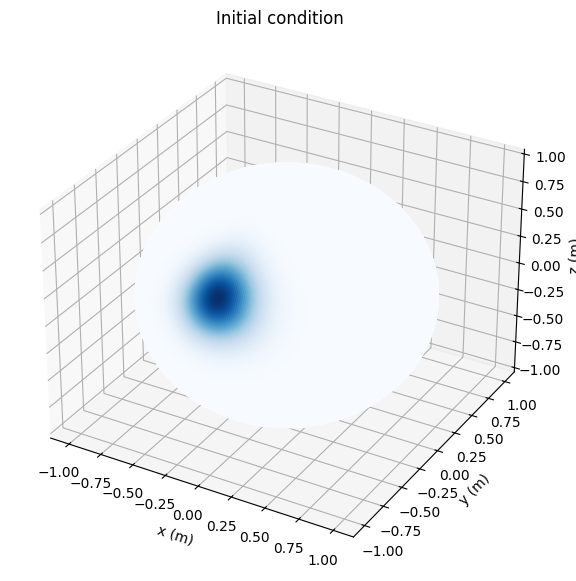

In [296]:
# Plot on a 3D surface
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=plt.cm.Blues(H), rstride=1, cstride=1, antialiased=True, shade=False)
ax.set_title('Initial condition')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

plt.show()

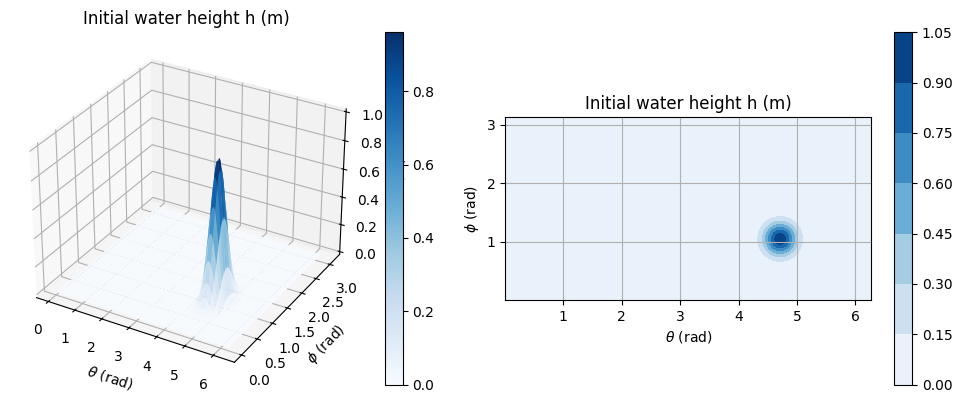

In [297]:
# Plot the initial data in 3d and in contour
cmap = 'Blues'
# Prepare grid for 3D plot
THETA, PHI = np.meshgrid(theta, phi)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')

surf = ax.plot_surface(THETA, PHI, H, cmap=cmap)
ax.set_title(f'Initial water height h (m)')
ax.set_xlabel(r'$\theta$ (rad)')
ax.set_ylabel(r'$\phi$ (rad)')
ax.set_zlabel('h (m)')
ax.grid()
#ax.set_aspect('equal')
fig.colorbar(surf, ax=ax)

ax2 = fig.add_subplot(122)
surf = ax2.contourf(THETA, PHI, H, cmap=cmap)
ax2.set_title(f'Initial water height h (m)')
ax2.set_xlabel(r'$\theta$ (rad)')
ax2.set_ylabel(r'$\phi$ (rad)')
ax2.grid()
ax2.set_aspect('equal')
fig.colorbar(surf, ax=ax2)

# Show the combined plot
plt.tight_layout()
plt.show()

In [ ]:
Q_all = []
Q_all.append(Q)

# Start timer
start_time = time.time()

# Time loop
for n in range(100000):
    sx = Lambdax(Q)  # characteristic velocities in x-direction
    sy = Lambday(Q)  # characteristic velocities in y-direction
    ax = np.max(np.abs(sx))
    ay = np.max(np.abs(sy))
    
    dt = CFL / (ax / d_theta + ay / d_phi)
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break

    # MUSCL part
    slopeX = np.zeros_like(Q)
    slopeY = np.zeros_like(Q)
    
    slopeX[:, 1:N_theta-1, :] = minmodarray(Q[:, 1:N_theta-1, :] - Q[:, 0:N_theta-2, :], Q[:, 2:N_theta, :] - Q[:, 1:N_theta-1, :])
    slopeY[:, :, 1:N_phi-1] = minmodarray(Q[:, :, 1:N_phi-1] - Q[:, :, 0:N_phi-2], Q[:, :, 2:N_phi] - Q[:, :, 1:N_phi-1])

    Qxm = Q - 0.5 * slopeX
    Qxp = Q + 0.5 * slopeX
    Qym = Q - 0.5 * slopeY
    Qyp = Q + 0.5 * slopeY

    Q_t = -(FluxX(Qxp) - FluxX(Qxm)) / d_theta - (FluxY(Qyp) - FluxY(Qym)) / d_phi
    Qxm += 0.5 * dt * Q_t
    Qxp += 0.5 * dt * Q_t
    Qym += 0.5 * dt * Q_t
    Qyp += 0.5 * dt * Q_t

    # Recompute physical fluxes and characteristic velocities for Rusanov flux
    fxm, fxp = FluxX(Qxm), FluxX(Qxp)
    gym, gyp = FluxY(Qym), FluxY(Qyp)
    
    sxm, sxp = Lambdax(Qxm), Lambdax(Qxp)
    sym, syp = Lambday(Qym), Lambday(Qyp)

    dtdx = dt / d_theta
    dtdy = dt / d_phi

    # Space loop
    for i in range(N_theta):
        for j in range(N_phi):
            # Numerical fluxes in X
            if i == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qghost, Qxm[:, i, j], FluxX(Qghost), fxm[:, i, j], Lambdax(Qghost), sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])
            elif i == N_theta - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qghost, fxp[:, i, j], FluxX(Qghost), sxp[:, i, j], Lambdax(Qghost))
            else:
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])

            # Numerical fluxes in Y
            if j == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost = Q[:, i, j].copy()
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qghost, Qym[:, i, j], FluxY(Qghost), gym[:, i, j], Lambday(Qghost), sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])
            elif j == N_phi - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost = Q[:, i, j].copy()
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qghost, gyp[:, i, j], FluxY(Qghost), syp[:, i, j], Lambday(Qghost))
            else:
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])

            # Finite volume update
            Qnew[:, i, j] = Q[:, i, j] - dtdx * (Fp - Fm) - dtdy * (Gp - Gm)
            

    # Update time and solution
    t += dt
    # Print t with 3 decimals
    print(f't = {t:.3f}')
    Q = np.copy(Qnew)
    Q_all.append(Q)

n = len(Q_all)
print(f'There are time steps: {n}')

# End timer
end_time = time.time()

# Print the time taken
elapsed_time = end_time - start_time
print(f'Time taken: {elapsed_time:.2f} seconds')


ValueError: operands could not be broadcast together with shapes (3,199,400) (3,200,400) 

In [ ]:
len(Q_all)

84

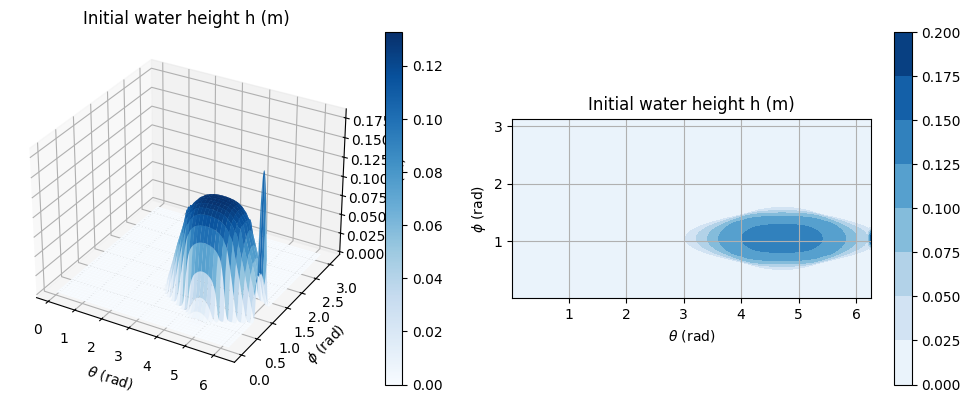

In [ ]:
idx = 80

# Plot the initial data in 3d and in contour
cmap = 'Blues'
# Prepare grid for 3D plot
THETA, PHI = np.meshgrid(theta, phi)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')

surf = ax.plot_surface(THETA, PHI, Q_all[idx][0, :, :], cmap=cmap)
ax.set_title(f'Initial water height h (m)')
ax.set_xlabel(r'$\theta$ (rad)')
ax.set_ylabel(r'$\phi$ (rad)')
ax.set_zlabel('h (m)')
ax.grid()
#ax.set_aspect('equal')
fig.colorbar(surf, ax=ax)

ax2 = fig.add_subplot(122)
surf = ax2.contourf(THETA, PHI, Q_all[idx][0, :, :], cmap=cmap)
ax2.set_title(f'Initial water height h (m)')
ax2.set_xlabel(r'$\theta$ (rad)')
ax2.set_ylabel(r'$\phi$ (rad)')
ax2.grid()
ax2.set_aspect('equal')
fig.colorbar(surf, ax=ax2)

# Show the combined plot
plt.tight_layout()
plt.show()

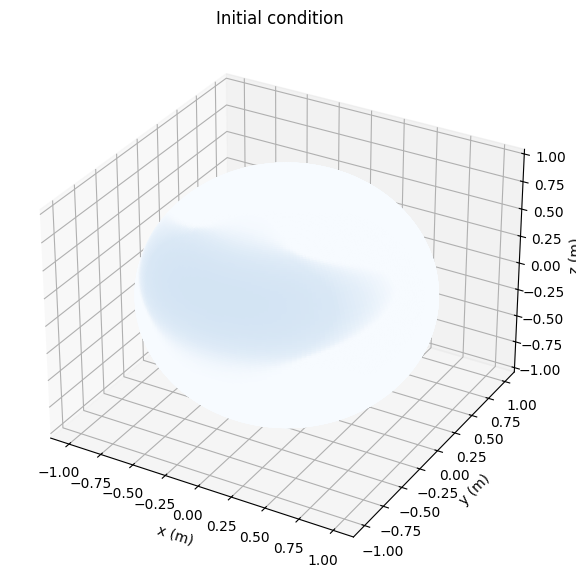

In [ ]:
idx = 60

# Plot on a 3D surface
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=plt.cm.Blues(Q_all[idx][0, :, :]), rstride=1, cstride=1, antialiased=True, shade=False)
ax.set_title('Initial condition')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

plt.show()